In [133]:
import MeCab

import japanize_matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import neologdn

from functools import reduce
from operator import add

from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

import plotly.io as pio
pio.renderers.default = 'iframe'

from tqdm import tqdm

In [3]:
df = pd.read_json('../../data/fc2b/fc2b.json')
df.sample(5)

,blog,entry,genre_id,genre_name,subgenre_id,subgenre_name,text,title,toxicity
2803,takanenohana55.blog.fc2.com,blog-entry-2925.html,46,趣味・実用,167,アウトドア・キャンプ,新聞にヒマラヤに咲く高嶺の花の写真展が高崎シティギャラリーで開催されていたので見てきました。...,ヒマラヤ大写真展 - 山,0
10301,ganshoji.blog.fc2.com,blog-entry-1642.html,28,学問・文化・芸術,283,哲学・思想,１２月の法語There are two inevitable things in life....,今月の法語 - 願勝寺のブログ,0
9107,hanahana1229.blog.fc2.com,blog-entry-2553.html,24,グルメ,190,レシピ,こんにちは！いかがお過ごしですか？課題フードつきジャケットの後ろ身頃を編んでいます。今日は、...,ベターホームを極める＆ル・コルドン・ブルーでパン作り&編み物 後ろ身頃を編んでいます♪,0
5431,utasuki0907.blog.fc2.com,blog-entry-3113.html,7,日記,7,主婦,Author:ルミネ\nルミネのブログへようこそ！２０１１年１０月からブログを始めました。花...,虹 | ルミネの日記,0
8690,egigagion.blog.fc2.com,blog-entry-3133.html,51,その他,332,その他,[PR]サラリーマンをやめて起業したのですが、借金だけが残り、お先真っ暗状態です（苦笑）「天...,天才脳開発パーフェクトブレインの東大医師・森田敏宏 wiki 情報 評判は？ - ココロ社,0


In [4]:
mecab = MeCab.Tagger("-F%m^%f[0]\\\\s")
POS = ('名詞', '動詞', '形容詞', '副詞')

text_tokens = []
for text in tqdm(df["text"].values):
    text = neologdn.normalize(text).strip()
    text = text.replace("^", "-")
    parsed = mecab.parse(text)
    if parsed:
        tokens = [node.split("^")[0] for node in parsed.strip().split() if "^" in node and node.split("^")[1] in POS]
        text_tokens.append(" ".join(tokens))
    else:
        text_tokens.append("")        
df["token"] = text_tokens

df = df[df["token"] != ""]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13867/13867 [00:46<00:00, 297.43it/s]


In [5]:
df[['toxicity', 'genre_name', 'title', 'token']].sample(5)

,toxicity,genre_name,title,token
11619,0,スポーツ,RAC-Official-Blog 12月18日(水) 衣笠練,"[ メンバー ] 1 回 し ほ ちゃん , ん ちゃん , けい , こい , そう , ..."
7415,0,アニメ・コミック,ロベルト・フェラーリさん帰国 - アニメに感謝,96 年 25 才 来日 し ロベルト さん タツノ コプロ 入社 さ れ 科学 忍者 隊 ...
2736,0,ニュース,地球 二〇三四 ビューティフルエナジー,2024 _ 1217 _ 火曜 ちょうど 頃 イエス マグダラ マリア 出会っ いる マグ...
12358,0,ライフ,リート買い増し 不動産比率 7割へ - 消費せず働きもしない未来を歩む遊民の独白,安かっ 買い どこ J - REIT 予想 とおり 安く なっ い もう少し 売り 続く 可...
5134,0,日記,「土手の伊勢屋」で天丼！ １時間３０分並びました！ - 天丼・かき揚げ丼,80 歳 マラッカ なう ! 日本人 墓地 行っ 後 焼き魚 魚 スープ ! こんなに 美味...


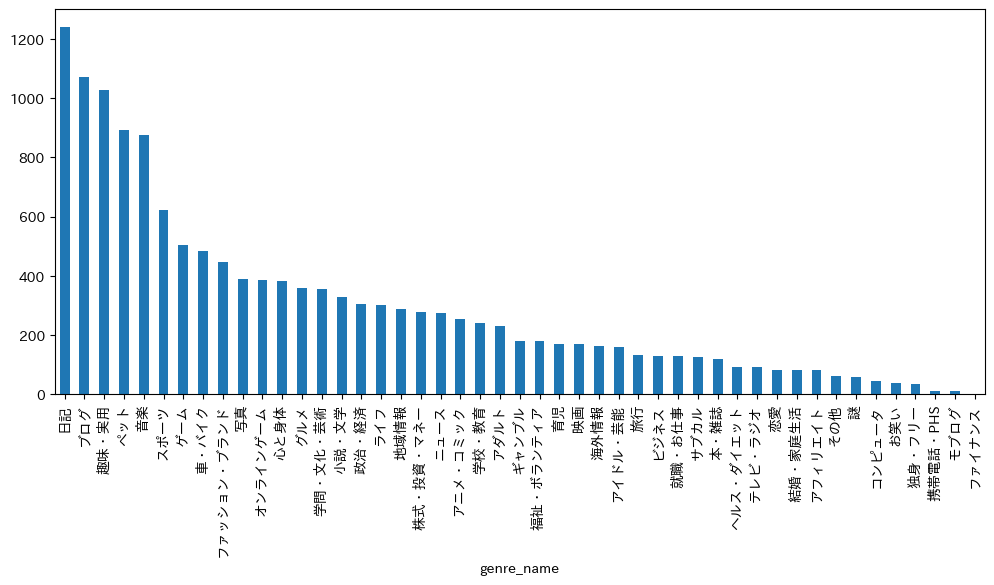

In [6]:
plt.figure(figsize=(12,5))

df["genre_name"].value_counts().plot(kind="bar")
plt.show()

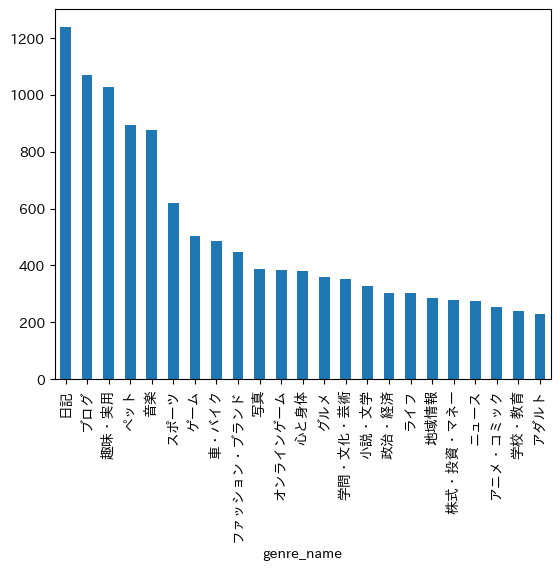

In [186]:
genres = df["genre_name"].value_counts().keys()[np.where((df["genre_name"].value_counts() > 200).values == True)].values
df = df.query("genre_name in @genres")

df["genre_name"].value_counts().plot(kind="bar")
plt.show()

In [187]:
def uniform_kfold(y, n_splits=3):
    np.random.seed(1234)

    labels = list(set(y))
    n_labels = len(labels)

    folds = [[[] for _ in range(n_labels)] for _ in range(n_splits)]

    for label in list(set(y)):
        label_count = list(y).count(label)
        label_indices = [i for i, y_i in enumerate(y) if y_i == label]
        np.random.shuffle(label_indices)
        for i, idx in enumerate(label_indices):
            folds[i % n_splits][labels.index(label)].append(idx)

    for n in range(n_splits):
        train_indices = reduce(add, [reduce(add, indices) for i, indices in enumerate(folds) if i != n])
        test_indices = reduce(add, folds[n])
        yield train_indices, test_indices

In [188]:
X = df['token'].values
y = df['genre_id'].values

data = [(train_indices, test_indices) for (train_indices, test_indices) in uniform_kfold(y, n_splits=3)]

def plot_kfold(data):
    fig = make_subplots(rows=len(data), cols=1, shared_xaxes=True, vertical_spacing = 0.03)
    for i, (train_indices, test_indices) in enumerate(data):
        fig.add_trace(go.Histogram(name='train', x=df.iloc[train_indices]["genre_name"].values, marker_color="blue"), row=i+1, col=1)
        fig.add_trace(go.Histogram(name='test', x=df.iloc[test_indices]["genre_name"].values, marker_color="red"), row=i+1, col=1)
    fig.update_layout(height=1000, width=1000, barmode='group', margin=dict(t=20, b=0, l=10, r=10), showlegend=False)
    fig.update_traces(opacity=0.5)
    fig.show()

plot_kfold(data)

In [189]:
kf = uniform_kfold(y, n_splits=3)
train_indices, test_indices = next(kf)

# 10　<= 単語の出現文書数 <= 文書数*0.3
cv = CountVectorizer(lowercase=True, max_df=0.3, min_df=10, max_features=8000)
#cv = TfidfVectorizer(lowercase=True, max_df=0.3, min_df=10, max_features=8000)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

print(X_train.shape, y_test.shape)

(7673, 8000) (3847,)


In [190]:
vocabs = cv.get_feature_names_out()

# 出現回数上位２０
display([(w, c) for w, c in zip(vocab[np.argsort(X_train.sum(axis=0))[-50:]][::-1], np.array(sorted(X_train.sum(axis=0))[-50:][::-1]))])
# 出現回数下位20
display([(w, c) for w, c in zip(vocab[np.argsort(X_train.sum(axis=0))[:50]], np.array(sorted(X_train.sum(axis=0))[:50]))])

[('robot', 12929),
 ('как', 10248),
 ('flowers', 9301),
 ('2018', 8440),
 ('posts', 7260),
 ('100', 6198),
 ('ca', 5450),
 ('small', 5156),
 ('110', 5124),
 ('five', 4901),
 ('projects', 4897),
 ('あんま', 4809),
 ('xx', 4529),
 ('お前', 4517),
 ('きら', 4418),
 ('97', 4341),
 ('たち', 4011),
 ('natural', 3956),
 ('かわり', 3846),
 ('お守り', 3756),
 ('いけ', 3753),
 ('following', 3721),
 ('1994', 3637),
 ('163', 3541),
 ('153', 3430),
 ('142', 3422),
 ('known', 3398),
 ('26', 3392),
 ('庭園', 3383),
 ('four', 3329),
 ('ドクター', 3264),
 ('switch', 3263),
 ('不満', 3214),
 ('昆虫', 3212),
 ('wi', 3162),
 ('af', 3156),
 ('整備', 3049),
 ('翌日', 2908),
 ('sound', 2875),
 ('単に', 2867),
 ('とおり', 2858),
 ('011', 2822),
 ('建設', 2789),
 ('firm', 2766),
 ('00', 2733),
 ('彼女', 2664),
 ('覚える', 2662),
 ('いまいち', 2618),
 ('130', 2594),
 ('終わる', 2553)]

[('188', 28),
 ('thus', 28),
 ('225', 28),
 ('プロデューサー', 28),
 ('parts', 28),
 ('優し', 28),
 ('writing', 28),
 ('有馬', 28),
 ('日頃', 28),
 ('偶然', 28),
 ('ゲー', 28),
 ('ボケ', 28),
 ('シングル', 28),
 ('movie', 28),
 ('move', 28),
 ('願っ', 28),
 ('137', 28),
 ('病院', 28),
 ('ニュース', 28),
 ('メーター', 28),
 ('馬鹿', 28),
 ('カウント', 28),
 ('ヤマ', 28),
 ('尽き', 28),
 ('使い', 28),
 ('女性', 28),
 ('woman', 28),
 ('without', 28),
 ('開い', 28),
 ('bank', 28),
 ('防止', 28),
 ('believe', 28),
 ('出前', 28),
 ('爆発', 28),
 ('冷静', 28),
 ('暮らす', 28),
 ('出張', 28),
 ('ハンド', 28),
 ('出船', 28),
 ('very', 28),
 ('牡蠣', 28),
 ('blogspot', 28),
 ('切っ', 28),
 ('開く', 28),
 ('昭恵', 28),
 ('box', 28),
 ('実験', 28),
 ('author', 28),
 ('公共', 28),
 ('刺繍', 28)]

In [191]:
kf = uniform_kfold(y, n_splits=3)
train_indices, test_indices = next(kf)

# 10　<= 単語の出現文書数 <= 文書数*0.3
cv = CountVectorizer(binary=True, lowercase=True, max_df=0.3, min_df=10, max_features=8000)
#cv = TfidfVectorizer(lowercase=True, max_df=0.3, min_df=10, max_features=8000)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

print(X_train.shape, y_test.shape)

(7673, 8000) (3847,)


In [192]:
clf = OneVsRestClassifier(LogisticRegression(max_iter=300, n_jobs=multiprocessing.cpu_count()-1, verbose=False))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [193]:
print("Accuracy Score        :", accuracy_score(y_test, y_pred))
print("Classification Report :\n", classification_report(y_test, y_pred))

Accuracy Score        : 0.5942292695606967
Classification Report :
               precision    recall  f1-score   support

          10       0.63      0.58      0.61       168
          11       0.67      0.42      0.52        85
          12       0.76      0.62      0.68       162
          15       0.75      0.77      0.76       149
          18       0.63      0.77      0.69       298
          22       0.41      0.55      0.47       357
          24       0.63      0.53      0.58       120
          25       0.62      0.53      0.57       130
          26       0.59      0.67      0.63       207
          28       0.51      0.43      0.47       118
          32       0.52      0.34      0.41       101
          34       0.69      0.51      0.59        96
          36       0.65      0.55      0.59       109
          38       0.76      0.49      0.60        80
          41       0.70      0.48      0.57       128
          42       0.93      0.70      0.80        93
          46 

In [194]:
y_preds, y_trues = [], []

for n, (train_indices, test_indices) in enumerate(uniform_kfold(y, n_splits=3)):
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    print(f'CV.{n} #Train={len(X_train)} #Test={len(X_test)}')

    cv = CountVectorizer(binary=True, lowercase=True, max_df=0.3, min_df=10, max_features=8000)

    X_train = cv.fit_transform(X_train).toarray()
    X_test = cv.transform(X_test).toarray()

    clf = OneVsRestClassifier(LogisticRegression(n_jobs=multiprocessing.cpu_count()-1, verbose=False))
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    y_preds.extend(y_pred)
    y_trues.extend(y_test)

CV.0 #Train=7673 #Test=3847
CV.1 #Train=7679 #Test=3841
CV.2 #Train=7688 #Test=3832


In [195]:
print("Accuracy Score        :", accuracy_score(y_trues, y_preds))
print("Classification Report :\n", classification_report(y_trues, y_preds))

Accuracy Score        : 0.5957465277777778
Classification Report :
               precision    recall  f1-score   support

          10       0.65      0.57      0.61       503
          11       0.62      0.39      0.48       253
          12       0.72      0.64      0.68       485
          15       0.73      0.72      0.73       446
          18       0.67      0.75      0.71       893
          22       0.40      0.53      0.46      1070
          24       0.61      0.53      0.57       358
          25       0.59      0.55      0.57       388
          26       0.65      0.65      0.65       621
          28       0.57      0.43      0.49       354
          32       0.59      0.37      0.46       302
          34       0.68      0.50      0.57       287
          36       0.66      0.52      0.58       327
          38       0.79      0.53      0.64       240
          41       0.63      0.52      0.57       382
          42       0.85      0.73      0.78       278
          46 

In [196]:
from sklearn.naive_bayes import MultinomialNB

y_preds, y_trues = [], []

for n, (train_indices, test_indices) in enumerate(uniform_kfold(y, n_splits=3)):
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    print(f'CV.{n} #Train={len(X_train)} #Test={len(X_test)}')

    cv = CountVectorizer(binary=True, lowercase=True, max_df=0.3, min_df=10, max_features=8000)

    X_train = cv.fit_transform(X_train).toarray()
    X_test = cv.transform(X_test).toarray()

    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    y_preds.extend(y_pred)
    y_trues.extend(y_test)

CV.0 #Train=7673 #Test=3847
CV.1 #Train=7679 #Test=3841
CV.2 #Train=7688 #Test=3832


In [197]:
print("Accuracy Score        :", accuracy_score(y_trues, y_preds))
print("Classification Report :\n", classification_report(y_trues, y_preds))

Accuracy Score        : 0.5358506944444444
Classification Report :
               precision    recall  f1-score   support

          10       0.53      0.57      0.55       503
          11       0.52      0.45      0.48       253
          12       0.68      0.59      0.63       485
          15       0.44      0.72      0.55       446
          18       0.52      0.74      0.61       893
          22       0.38      0.28      0.33      1070
          24       0.43      0.61      0.50       358
          25       0.49      0.50      0.49       388
          26       0.67      0.62      0.64       621
          28       0.52      0.33      0.40       354
          32       0.65      0.26      0.37       302
          34       0.63      0.33      0.43       287
          36       0.49      0.55      0.52       327
          38       0.76      0.55      0.64       240
          41       0.61      0.50      0.55       382
          42       0.78      0.76      0.77       278
          46 